Plot tas on days with (without) melt
===

In [1]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}

from netCDF4 import Dataset
import pandas as pd
import numpy as np
from scipy import stats
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.text import Text

%load_ext autoreload
%autoreload 2
from model import Model
from GCNet import GCNet
from plotUtils import PlotUtils
from itertools import izip

pd.options.mode.chained_assignment = None

Global data
---

In [2]:
yr1a = "1996"
yr2a = "2005"
linewidth = 4

# Mlsm = Model("wrf_geog.nc", "landmask.nc")
# lsm2d = Mlsm.loadData( "LANDMASK", True )
# lsm = lsm2d.values.reshape(-1,).tolist()

# Morog = Model("wrf_geog.nc", "lat_lon_orog.nc")
# orog2d = Morog.loadData( "orog", True )
# orog = orog2d.values.reshape(-1,).tolist()

Function: Remove masked elements
---

In [3]:
def compress(data, selectors):
    # compress('ABCDEF', [1,0,1,0,1,1]) --> A C E F
    return (d for d, s in izip(data, selectors) if s)

Function: Load and prepare a data file
---

In [4]:
def loadData( var, model, period, mms, yrs, suff, mask, site = None ):
    # Load data, convert to 1-d
    
    if model == "melt":
        modelDir = "/Users/dbr/Documents/gismelt/mote_sfc_melt"
        if site is None:
            modelFN = "Mote_"+yrs+"_"+mms+".nc"
        else:
            modelFN = "wrf_mote_melt_closest_"+yrs+"_"+mms+".nc"
    if model == "erai":
        if site is None:
            modelDir = "/Volumes/sbp1/model/pwrf/gis_erai/historical/wrf/postproc/tas"
            modelFN = var+"_wrf_erai_"+yrs+"_"+mms+"_d.nc"
        else:
            modelDir = "/Users/dbr/Documents/gismelt/models_vs_obs/gis_erai"
            modelFN = "wrf_erai_"+var+"_closest_"+yrs+"_"+mms+".nc"
    if model == "cesmle":
        if site is None:
            modelDir = "/Volumes/sbp1/model/pwrf/gis_cesmle/"+period+"/wrf/postproc/tas/ens"
            if suff is None:
                modelFN = var+"_wrf_cesmle_ens_"+yrs+"_"+mms+"_d.nc"
            else:
                modelFN = var+"_wrf_cesmle_ens_"+yrs+"_"+mms+"_d_"+suff+".nc"
        else:
            modelDir = "/Users/dbr/Documents/gismelt/models_vs_obs/gis_cesmle"
            if suff is None:
                modelFN = "wrf_cesmle_ens_"+var+"_closest_"+yrs+"_"+mms+".nc"
            else:
                modelFN = "wrf_cesmle_ens+"+var+"_closest_"+yrs+"_"+mms+"_"+suff+".nc"

    if model == "cesmlw":
        if site is None:
            modelDir = "/Volumes/sbp1/model/pwrf/gis_cesmlw/"+period+"/wrf/postproc/tas/ens"
            if suff is None:
                modelFN = var+"_wrf_cesmlw_ens_"+yrs+"_"+mms+"_d.nc"
            else:
                modelFN = var+"_wrf_cesmlw_ens_"+yrs+"_"+mms+"_d_"+suff+".nc"
        else:
            modelDir = "/Users/dbr/Documents/gismelt/models_vs_obs/gis_cesmlw"
            if suff is None:
                modelFN = "wrf_cesmlw_ens_"+var+"_closest_"+yrs+"_"+mms+".nc"
            else:
                modelFN = "wrf_cesmlw_ens_"+var+"_closest_"+yrs+"_"+mms+"_"+suff+".nc"
        
    if site is None:
        M = Model("wrf_geog.nc", modelDir+"/"+modelFN)
        X = M.loadData( var, True, -2 )
    else:
        A = GCNet("site_info.nc", modelDir+"/"+modelFN)
        A.loadMeta()
        M = A.loadData( var, True )
        if not site is None:
            X = M[site]
        else:
            X = M

    X1d = X.values.reshape(-1,).tolist()
#     print "X1d: "+str(len(X1d))+" points, min = "+str(min(X1d))
    
    if mask is None:
        X1dMask = X1d
    else:
        maskVar = mask[0]
        if maskVar == "lsm":  # masking against landsea mask
            X1dMask = list( compress( X1d, lsm ) )
        else:
            if maskVar == "orog":  # masking against orography
                X1dLSM = np.array( list( compress( X1d, lsm )))
                orogLSM = np.array( list( compress( orog, lsm )))
                maskElev = mask[1]
                if maskElev > 0:
                    msk = np.where( orogLSM > abs(maskElev) )[0]
                    X1dMask = X1dLSM[ msk ].tolist()
#                     X1dMask = X1dLSM[ np.where( orogLSM > maskElev ) ].tolist()
                else:
                    msk = np.where( orogLSM < abs(maskElev) )[0]
                    X1dMask = X1dLSM[ msk ].tolist()
#                     X1dMask = X1dLSM[ np.where( orogLSM < abs(maskElev) ) ].tolist()
            else:
                print "Mask variable not recognized"
                return None
    
    return X1dMask

Function: Make Kernel Density Estimate plot
---

In [5]:
def plotData( X, bw = None ):
    if bw is None:
        bw = 0.2
    sns.kdeplot( X, cut=0, bw=bw, linewidth=linewidth )

Function: Mask elements
---

In [6]:
def maskData( X, Y, mask ):
    mskix = np.where(np.array(Y) == mask )[0]
    msklist = np.zeros(len(Y))
    if len(mskix) > 0:
        msklist[mskix] = 1
    msklist = msklist.tolist()
    X2 = list( compress( X, msklist ))
    Y2 = list( compress( Y, msklist ))
    return ( X2, Y2 )

Function: Drop NaN elements
---

In [7]:
def dropNaN( X, Y, theNaN = None ):
    if theNaN is None:
        nanix = np.where(np.isnan(np.array(Y)))[0]
    else:
        if theNaN > 0:
            nanix = np.where(np.array(Y) > theNaN )[0]
        else:
            nanix = np.where(np.array(Y) < theNaN )[0]
    nanlist = np.ones(len(Y))
    nanlist[nanix] = 0
    nanlist = nanlist.tolist()
    X2 = list( compress( X, nanlist ))
    Y2 = list( compress( Y, nanlist ))
    return ( X2, Y2 )

Function: Add a legend
---

In [8]:
def addLegend( ax, loc, legText = None):
    h = ax.lines
    if legText is None:
        lbls = ['Melt days','No-melt days']
    else:
        lbls = legText
    ax.legend(handles = h, \
              labels = lbls, \
              loc = loc, \
              fancybox = True, \
              edgecolor = 'black', \
              frameon = True, \
              fontsize = 14);

Function: Mask elements below a certain value
---

In [9]:
def maskDataBelow( X, mask ):
    X2 = np.copy( X )
    mskix = np.where(X < mask)[0]
    if len(mskix) > 0:
        X2[mskix] = np.nan
#         X2[mskix] = 0
    return ( X2, mskix )

Function: Clean up time series
---

In [10]:
def cleanTimeSeries( X, Y, debug = None ):
    # clean time series by testing against values in either X or Y
    # drop days where X data is _FillValue
    Y2, X2 = dropNaN( Y, X, 1.e3 )
    if not debug is None:
        print "Orig len: "+str(len(X))+", X FillValue-filtered len: "+str(len(X2))

    # drop days where X data is "nan"
    Y3, X3 = dropNaN( Y2, X2 )
    if not debug is None:
        print "Orig len: "+str(len(X2))+", X NaN-filtered len: "+str(len(X3))

    # drop days where Y data is "NaN"
    X4, Y4 = dropNaN( X3, Y3, -1. )
    if not debug is None:
        print "Orig len: "+str(len(X3))+", Y NaN-filtered len: "+str(len(X4))

    return (X4, Y4)

Function: Annotate plot
---

In [11]:
def annotatePlot( title, xlabel, ylabel, legend, legloc ):
    ax = plt.gca()
    plt.title( title, fontsize=18 );
    plt.xlabel( xlabel, fontsize=16 );
    plt.ylabel( ylabel, fontsize=16 );
    if legloc is None:
        legloc = 'best'
    addLegend( ax, legloc, legend )
    plt.xticks(fontsize=14, rotation=0)
    plt.yticks(fontsize=14, rotation=0)

Function: convert KDE to transition function
---

In [12]:
def transitionFN( xs, Xm, Xnm, smthIX = 20 ):
    # copy input vars
    Xm2 = np.copy(Xm)
    Xnm2 = np.copy(Xnm)
    
    # find maximum values
    ixXm = np.argmax(Xm)
    ixXnm = np.argmax(Xnm)

    # set pieces of each var outside overlap to nan
    Xm2[0:ixXnm] = np.nan
    Xm2[(ixXm+1):] = np.nan
    Xnm2[(ixXm+1):] = np.nan
    Xnm2[0:ixXnm] = np.nan

    # calculate P(melt)
    Pm = Xm2 / ( Xm2 + Xnm2 )
    minPm = Pm[ixXnm]
    maxPm = Pm[ixXm]
    
    # adjusted indices
    ixXmAdj  = ixXm + smthIX
    ixXnmAdj = ixXnm - smthIX
    
    # smooth the part between min/max and 0/1
    Pm[0:ixXnmAdj] = 0
    infill = np.linspace(0, minPm, num = smthIX)
    Pm[ixXnmAdj:ixXnm] = infill
    
    Pm[ixXmAdj:] = 1
    infill = np.linspace(maxPm, 1, num = smthIX)
    Pm[ixXm:ixXmAdj:] = infill

    # make in-between linear
    npts = (ixXm + smthIX) - (ixXnm - smthIX)
    infill = np.linspace(0, 1, num = npts)
    Pm[ixXnmAdj:ixXmAdj] = infill
    
    # likelihood of no-melt = 1 - P(melt)
    Pnm = 1 - Pm
    
    # transition point values
    xLwr = round( xs[ixXnmAdj],1 )
    xUpr = round( xs[ixXmAdj],1 )

    # calculate linear regression parameters
    m = (1. - 0.) / (xUpr - xLwr)
    b = 1. - m*xUpr
    
    return Pm, Pnm, xLwr, xUpr, m, b

More global data
---

In [13]:
# yrsHist = yr1a+"-"+yr2a
yrsHist = yr1a+"-"+yr2a
bw = 0.4
site = None

tas
----

In [14]:
mms = "06"
period = "historical"
suff = None
mask = None

mlt = loadData( "greenland_surface_melt", "melt", period, mms, yrsHist, suff, mask )
tas = loadData( "tas", "cesmle", period, mms, yrsHist, suff, mask )
print "Data series: "+str(len(mlt))+", "+str(len(tas))

# drop FillValues, NaNs
tas, mlt = cleanTimeSeries( tas, mlt, True )

# stratify into melt/no-melt using melt data
tasm, mltm = maskData( tas, mlt, 1 )
print "Melt: "+str(len(tasm)), str(len(mltm))

tasnm, mltnm = maskData( tas, mlt, 0 )
print "No-melt: "+str(len(tasnm)), str(len(tasnm))

Data series: 12942900, 12942900
Orig len: 12942900, X FillValue-filtered len: 12942900
Orig len: 12942900, X NaN-filtered len: 12942900
Orig len: 12942900, Y NaN-filtered len: 2337237
Melt: 415621 415621
No-melt: 1921616 1921616


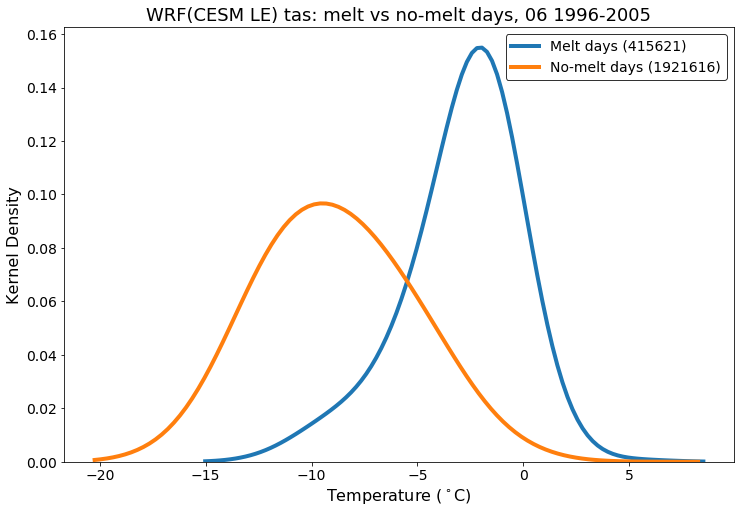

In [15]:
# make KDE plot
fig, ax = plt.subplots( figsize=(12,8))
plotData( tasm, bw )
plotData( tasnm, bw )

xlabel = 'Temperature ($^\circ$C)'
ylabel = 'Kernel Density'
if not site is None:
    title = "WRF(CESM LE) "+site+" tas: melt vs no-melt days, "+mms+" "+yrsHist
else:
    title = "WRF(CESM LE) tas: melt vs no-melt days, "+mms+" "+yrsHist
legend = [ 'Melt days ('+str(len(tasm))+')', 'No-melt days ('+str(len(tasnm))+')' ]
annotatePlot( title, xlabel, ylabel, legend, None )
   
xmin, xmax = ax.get_xlim();

Isolate overlap to analyze transition between melt/no-melt temperatures
----

In [16]:
# generate KDE's directly
xs = np.arange(min(tas), max(tas), 0.1)
Km = stats.gaussian_kde( tasm, bw_method=bw )
Xm = np.array(Km(xs))
Knm = stats.gaussian_kde( tasnm, bw_method=bw )
Xnm = np.array(Knm(xs))

In [17]:
# Alternative way to plot:  do the generated series instead of using kdeplot()
# fig, ax = plt.subplots( figsize=(12,8))
# plt.plot(xs, Xm, linewidth=linewidth)
# plt.plot(xs, Xnm, linewidth=linewidth)
# addLegend( ax, [ 'Melt days', 'No-melt days' ] )
# xmin, xmax = ax.get_xlim();

# if not site is None:
#     plt.title("KDE WRF(ERAI) "+site+" tas: melt vs no-melt days, "+mms+" "+yrsHist, fontsize=16);
# else:
#     plt.title("KDE WRF(ERAI) tas: melt vs no-melt days, "+mms+" "+yrsHist, fontsize=16);

Lower break = -10.4, Upper break = -1.0
slope = 0.11, intercept = 1.11


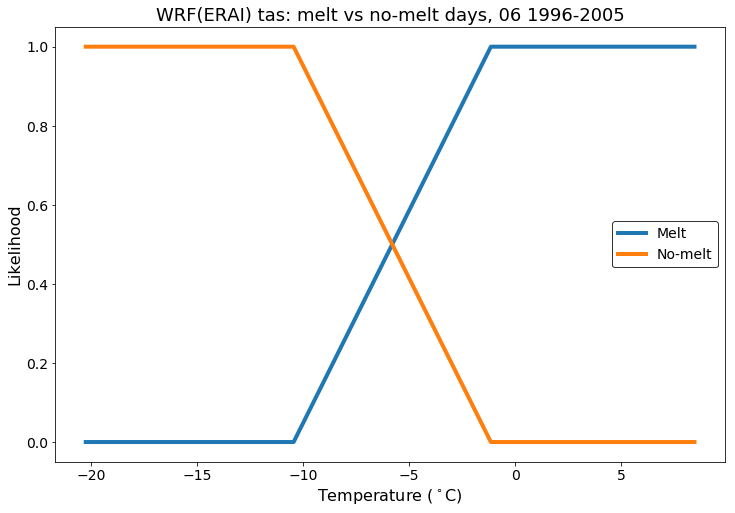

In [18]:
# make plot of transition functions
Pm, Pnm, xLwr, xUpr, m, b = transitionFN( xs, Xm, Xnm, 10 )
print "Lower break = %.1f, Upper break = %.1f" % ( xLwr, xUpr )
print "slope = %.2f, intercept = %.2f" % ( m, b )
# xMid = (xUpr + xLwr) / 2.
# yMid = m*xMid + b
# print xMid, yMid

fig, ax = plt.subplots( figsize=(12,8))
plt.plot(xs, Pm, linewidth = linewidth)
plt.plot(xs, Pnm, linewidth = linewidth)
# plt.plot( xMid, yMid, 'ro', markersize = 20)

xlabel = 'Temperature ($^\circ$C)'
ylabel = 'Likelihood'
if not site is None:
    title = "WRF(ERAI) "+site+" tas: melt vs no-melt, "+mms+" "+yrsHist
else:
    title = "WRF(ERAI) tas: melt vs no-melt days, "+mms+" "+yrsHist
legend = [ 'Melt', 'No-melt' ]
annotatePlot( title, xlabel, ylabel, legend, None )

# xmin, xmax = ax.get_xlim();
# ax.set_xlim( xmin, xmax );
# ax.set_xlim(-7,3)

tas at AWS sites
----

In [29]:
# mm = "JJA"
mm = 8
period = "hist"
suff = None
mask = None
site = "Swiss Camp"

try:
    mms = "%02d" % mm
except TypeError:
    mms = mm

mlt = loadData( "greenland_surface_melt", "melt", period, mms, yrsHist, suff, mask, site )
tas = loadData( "tas", "erai", period, mms, yrsHist, suff, mask, site )
print "Data series: "+str(len(mlt))+", "+str(len(tas))

# drop FillValues, NaNs
tas, mlt = cleanTimeSeries( tas, mlt, True )

# stratify into melt/no-melt using melt data
tasm, mltm = maskData( tas, mlt, 1 )
print "Melt: "+str(len(tasm)), str(len(mltm))

tasnm, mltnm = maskData( tas, mlt, 0 )
print "No-melt: "+str(len(tasnm)), str(len(tasnm))

Data series: 310, 310
Orig len: 310, X FillValue-filtered len: 310
Orig len: 310, X NaN-filtered len: 310
Orig len: 310, Y NaN-filtered len: 309
Melt: 144 144
No-melt: 165 165


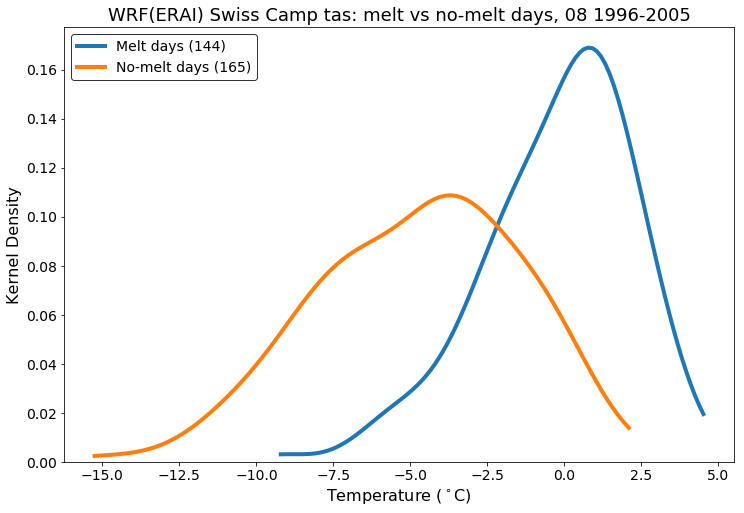

In [30]:
# make KDE plot
fig, ax = plt.subplots( figsize=(12,8))
plotData( tasm, bw )
plotData( tasnm, bw )

xlabel = 'Temperature ($^\circ$C)'
ylabel = 'Kernel Density'
if not site is None:
    title = "WRF(ERAI) "+site+" tas: melt vs no-melt days, "+mms+" "+yrsHist
else:
    title = "WRF(ERAI) tas: melt vs no-melt days, "+mms+" "+yrsHist
legend = [ 'Melt days ('+str(len(tasm))+')', 'No-melt days ('+str(len(tasnm))+')' ]
annotatePlot( title, xlabel, ylabel, legend, None )
   
xmin, xmax = ax.get_xlim();

Isolate overlap to analyze transition between melt/no-melt temperatures
----

In [31]:
# generate KDE's directly
xs = np.arange(min(tas), max(tas), 0.1)
Km = stats.gaussian_kde( tasm, bw_method=bw )
Xm = np.array(Km(xs))
Knm = stats.gaussian_kde( tasnm, bw_method=bw )
Xnm = np.array(Knm(xs))

In [32]:
# Alternative way to plot:  do the generated series instead of using kdeplot()
# fig, ax = plt.subplots( figsize=(12,8))
# plt.plot(xs, Xm, linewidth=linewidth)
# plt.plot(xs, Xnm, linewidth=linewidth)
# addLegend( ax, [ 'Melt days', 'No-melt days' ] )
# xmin, xmax = ax.get_xlim();

# if not site is None:
#     plt.title("KDE WRF(ERAI) "+site+" tasmax: melt vs no-melt days, "+mms+" "+yrsHist, fontsize=16);
# else:
#     plt.title("KDE WRF(ERAI) tasmax: melt vs no-melt days, "+mms+" "+yrsHist, fontsize=16);

Lower break = -4.3, Upper break = 1.3
slope = 0.18, intercept = 0.77


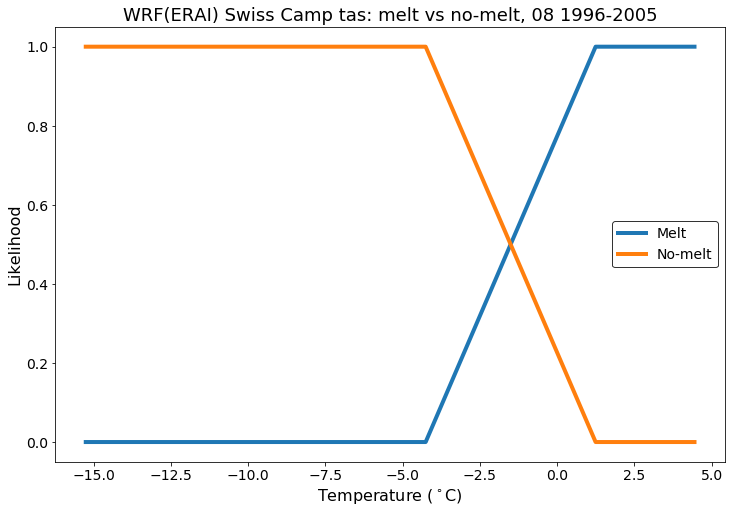

In [39]:
# make plot of transition functions
Pm, Pnm, xLwr, xUpr, m, b = transitionFN( xs, Xm, Xnm, 5 )
print "Lower break = %.1f, Upper break = %.1f" % ( xLwr, xUpr )
print "slope = %.2f, intercept = %.2f" % ( m, b )

# xMid = (xUpr + xLwr) / 2.
# yMid = m*xMid + b
# print xMid, yMid

fig, ax = plt.subplots( figsize=(12,8))
plt.plot(xs, Pm, linewidth = linewidth)
plt.plot(xs, Pnm, linewidth = linewidth)
# plt.plot( xMid, yMid, 'ro', markersize = 20)

xlabel = 'Temperature ($^\circ$C)'
ylabel = 'Likelihood'
if not site is None:
    title = "WRF(ERAI) "+site+" tas: melt vs no-melt, "+mms+" "+yrsHist
else:
    title = "WRF(ERAI) tas: melt vs no-melt days, "+mms+" "+yrsHist
legend = [ 'Melt', 'No-melt' ]
annotatePlot( title, xlabel, ylabel, legend, None )

# ax.set_xlim( xmin, xmax );

tasmax: Not Available So Skipped
----

In [34]:
# # mms = "06"
# # period = "hist"
# # suff = None
# # mask = None

# mlt = loadData( "greenland_surface_melt", "melt", period, mms, yrsHist, suff, mask )
# tas = loadData( "tasmax", "erai", period, mms, yrsHist, suff, mask )
# print "Data series: "+str(len(mlt))+", "+str(len(tas))

# # drop FillValues, NaNs
# tas, mlt = cleanTimeSeries( tas, mlt, True )

# # stratify into melt/no-melt using melt data
# tasm, mltm = maskData( tas, mlt, 1 )
# print "Melt: "+str(len(tasm)), str(len(mltm))

# tasnm, mltnm = maskData( tas, mlt, 0 )
# print "No-melt: "+str(len(tasnm)), str(len(tasnm))

In [35]:
# # make KDE plot
# fig, ax = plt.subplots( figsize=(12,8))
# plotData( tasm, bw )
# plotData( tasnm, bw )

# xlabel = 'Temperature ($^\circ$C)'
# ylabel = 'Kernel Density'
# if not site is None:
#     title = "WRF(ERAI) "+site+" tasmax: melt vs no-melt days, "+mms+" "+yrsHist
# else:
#     title = "WRF(ERAI) tasmax: melt vs no-melt days, "+mms+" "+yrsHist
# legend = [ 'Melt days ('+str(len(tasm))+')', 'No-melt days ('+str(len(tasnm))+')' ]
# annotatePlot( title, xlabel, ylabel, legend, None )
   
# xmin, xmax = ax.get_xlim();

Isolate overlap to analyze transition between melt/no-melt temperatures
----

In [36]:
# # generate KDE's directly
# xs = np.arange(min(tas), max(tas), 0.1)
# Km = stats.gaussian_kde( tasm, bw_method=bw )
# Xm = np.array(Km(xs))
# Knm = stats.gaussian_kde( tasnm, bw_method=bw )
# Xnm = np.array(Knm(xs))

In [37]:
# Alternative way to plot:  do the generated series instead of using kdeplot()
# fig, ax = plt.subplots( figsize=(12,8))
# plt.plot(xs, Xm, linewidth=linewidth)
# plt.plot(xs, Xnm, linewidth=linewidth)
# addLegend( ax, [ 'Melt days', 'No-melt days' ] )
# xmin, xmax = ax.get_xlim();

# if not site is None:
#     plt.title("KDE WRF(ERAI) "+site+" tasmax: melt vs no-melt days, "+mms+" "+yrsHist, fontsize=16);
# else:
#     plt.title("KDE WRF(ERAI) tasmax: melt vs no-melt days, "+mms+" "+yrsHist, fontsize=16);

In [38]:
# # make plot of transition functions
# Pm, Pnm, xLwr, xUpr, m, b = transitionFN( xs, Xm, Xnm, 10 )
# print xLwr, xUpr
# print m, b

# # xMid = (xUpr + xLwr) / 2.
# # yMid = m*xMid + b
# # print xMid, yMid

# fig, ax = plt.subplots( figsize=(12,8))
# plt.plot(xs, Pm, linewidth = linewidth)
# plt.plot(xs, Pnm, linewidth = linewidth)
# # plt.plot( xMid, yMid, 'ro', markersize = 20)

# xlabel = 'Temperature ($^\circ$C)'
# ylabel = 'Likelihood'
# if not site is None:
#     title = "WRF(ERAI) "+site+" tasmax: melt vs no-melt, "+mms+" "+yrsHist
# else:
#     title = "WRF(ERAI) tasmax: melt vs no-melt days, "+mms+" "+yrsHist
# legend = [ 'Melt', 'No-melt' ]
# annotatePlot( title, xlabel, ylabel, legend, None )

# # ax.set_xlim( xmin, xmax );